<a href="https://colab.research.google.com/github/dscho15/deep-learning/blob/main/Lecture8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [81]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
from tqdm.notebook import tqdm
from scipy import ndimage
from google_drive_downloader import GoogleDriveDownloader as gdd

# Online resources used:

https://debuggercafe.com/getting-started-with-variational-autoencoder-using-pytorch/

https://www.youtube.com/watch?v=IQpP_cH8rrA

https://github.com/rasbt/stat453-deep-learning-ss21 WELL!!

In [82]:
gdd.download_file_from_google_drive('1Uzgc9c0MSYP4y9ia7mvwCGggjhTDEmrk', '~/img_align_celeba_50k.npz')
blob = np.load('~/img_align_celeba_50k.npz')
x_train, x_test = blob['x_train'], blob['x_test']
dim = x_train.shape[1:]
n_valid = 2000
x_train, x_valid = x_train[:-n_valid], x_train[-n_valid:]

print(f'x_train shape: {x_train.shape}')
print(f'x_valid shape: {x_valid.shape}')
print(f'dtype: {x_train.dtype}')

x_train shape: (48000, 32, 32, 3)
x_valid shape: (2000, 32, 32, 3)
dtype: float32


In [89]:
x_train_blur = np.empty_like(x_train)
for i in tqdm(range(len(x_train))):
  # apply your noise model here
  # x_train_blur[i] = cv2.GaussianBlur(x_train[i], (3, 3), cv2.BORDER_DEFAULT)
  x_train_blur[i] = x_train[i]

x_valid_blur = np.empty_like(x_valid)
for i in tqdm(range(len(x_valid))):
  # apply your noise model here
  # x_valid_blur[i] = cv2.GaussianBlur(x_valid[i], (3, 3), cv2.BORDER_DEFAULT)
  x_valid_blur[i] = x_valid[i]

  0%|          | 0/48000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [91]:
def plot_rows(*img_rows, scale=1.):
  rows = len(img_rows)
  cols = len(img_rows[0])
  fig, axs = plt.subplots(rows, cols, figsize=(cols * scale, rows * scale))
  for i, img_row in enumerate(img_rows):
      for j, im in enumerate(img_row):
          ax = axs[i, j]
          ax.imshow(np.clip(im, 0, 1))
          ax.axis('off')
  plt.tight_layout()
  plt.show()

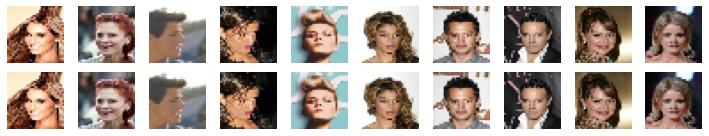

In [92]:
plot_rows(x_train[:10], x_train_blur[:10])

In [93]:
mu, std = np.mean(x_train, axis=(0, 1, 2)), np.std(x_train, axis=(0, 1, 2))
print("mu: ", mu, " sigma: ", std)

def norm(a):
  return torch.from_numpy((a - mu) / std).permute(0, 3, 1, 2)

def denorm(a):
  return a.detach().cpu().permute(0, 2, 3, 1).numpy() * std + mu

x_train_normed = norm(x_train)
x_valid_normed = norm(x_valid)
x_train_blur_normed = norm(x_train_blur)
x_valid_blur_normed = norm(x_valid_blur)

mu:  [0.34133333 0.34133333 0.34133333]  sigma:  [0.32654327 0.27426648 0.2628333 ]


In [203]:
class VAE(nn.Module):

  def __init__(self, 
               input_channels = 3,
               hidden_channels = 16,
               kernel_size = 3,
               latent_dim = 128):

    super(VAE, self).__init__()

    self.encode = model = nn.Sequential( 
                                          nn.Conv2d(input_channels, hidden_channels, kernel_size, stride = 2, padding = 1),
                                          nn.LeakyReLU(inplace=True),

                                          nn.Conv2d(hidden_channels, hidden_channels*2, kernel_size, stride = 2, padding = 1),
                                          nn.BatchNorm2d(hidden_channels*2),
                                          nn.LeakyReLU(inplace=True),
                                          
                                          nn.Conv2d(hidden_channels*2, hidden_channels*4, kernel_size, stride = 2, padding = 1),
                                          nn.LeakyReLU(inplace=True),
                                         
                                          nn.Conv2d(hidden_channels*4, hidden_channels*8, kernel_size, stride = 2, padding = 1),
                                          nn.LeakyReLU(inplace=True)
                                        )


    self.decode = model = nn.Sequential( 
                                          nn.ConvTranspose2d(hidden_channels*8, hidden_channels*4, kernel_size, stride = 2, padding = 1, output_padding = 1),
                                          nn.LeakyReLU(inplace=True),

                                          nn.ConvTranspose2d(hidden_channels*4, hidden_channels*2, kernel_size, stride = 2, padding = 1, output_padding = 1),
                                          nn.BatchNorm2d(hidden_channels*2),
                                          nn.LeakyReLU(inplace=True),

                                          nn.ConvTranspose2d(hidden_channels*2, hidden_channels, kernel_size, stride = 2, padding = 1, output_padding = 1),
                                          nn.LeakyReLU(inplace=True),
                                          
                                          nn.ConvTranspose2d(hidden_channels, input_channels, kernel_size, stride = 2, padding = 1, output_padding = 1)
                                        )
    
    self.fc_mu = nn.Linear(hidden_channels * 2**5, latent_dim)
    self.fc_log_var = nn.Linear(hidden_channels * 2**5, latent_dim)
    self.fc_dec = nn.Linear(latent_dim, hidden_channels * 2**5)

  def forward(self, x):
    """
    :param x: the batch input, an image.
    """

    # encoder part - output is a B x 128 x 2 x 2
    h = self.encode(x).view(-1, 512)

    # calculate mu and var
    mu = self.fc_mu(h)
    log_var = self.fc_log_var(h)

    # mu and var is techinically the ouput of the encoder.
    p = self.reparameterize(mu, log_var)

    # decoder part
    y = self.fc_dec(p).view(-1, 128, 2, 2)
    return [self.decode(y), input, mu, log_var]

  def reparameterize(self, mu, log_var):
    """
    :param mu: mean from the encoder's latent space
    :param log_var: log variance from the encoder's latent space
    """

    std = torch.exp(0.5*log_var) # standard deviation
    eps = torch.randn_like(std) # we need same size as std

    sample = mu + (eps * std)
    return sample


In [179]:
train_data = list(zip(x_train_blur_normed, x_train_normed))
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=2)

valid_data = list(zip(x_valid_blur_normed, x_valid_normed))
valid_dataloader = torch.utils.data.DataLoader(valid_data, batch_size=64, shuffle=True, num_workers=2)

  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 0, mse loss (train/valid): 0.7645/0.5196
epoch: 1, mse loss (train/valid): 0.4520/0.4199
epoch: 2, mse loss (train/valid): 0.3945/0.3848
epoch: 3, mse loss (train/valid): 0.3714/0.3670
epoch: 4, mse loss (train/valid): 0.3576/0.3571
epoch: 5, mse loss (train/valid): 0.3459/0.3468
epoch: 6, mse loss (train/valid): 0.3383/0.3403
epoch: 7, mse loss (train/valid): 0.3333/0.3357
epoch: 8, mse loss (train/valid): 0.3292/0.3281
epoch: 9, mse loss (train/valid): 0.3258/0.3294


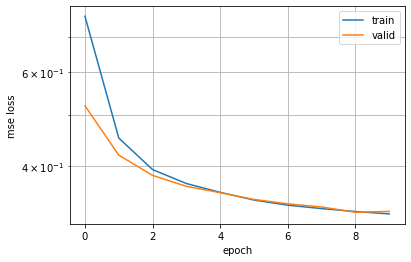

In [202]:
model = VAE(input_channels = 3, hidden_channels = 16, kernel_size = 3).cuda()
opt = torch.optim.Adam(model.parameters(), lr=1e-4)

train_losses = []
valid_losses = []

for epoch in tqdm(range(10)):
    losses = []
    for x, y in train_dataloader:
      x, y = x.cuda(), y.cuda()
      y_hat, _, mu, log_var  = model(x)
      kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim = 1), dim = 0)
      loss = F.mse_loss(y_hat, y) + kld_loss * 0.002
      opt.zero_grad()
      loss.backward()
      opt.step()

      losses.append(loss.item())

    train_losses.append(np.mean(losses))

    losses = []
    for x, y in valid_dataloader:
        x, y = x.cuda(), y.cuda()
        y_hat, _, mu, log_var  = model(x)
        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim = 1), dim = 0)
        loss = F.mse_loss(y_hat, y) + kld_loss * 0.002
        losses.append(loss.item())
    valid_losses.append(np.mean(losses))

    print(f'epoch: {epoch}, mse loss (train/valid): {train_losses[-1]:.4f}/{valid_losses[-1]:.4f}')

plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.ylabel('mse loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.grid(which='both')
plt.legend()
plt.show()

In [204]:
def plot_imgs(idx):
  plt.figure(idx, figsize=(2, 2))
  img1 = train_data[idx][0].reshape((1, 3, 32, 32)).cuda()
  img1 = img1.cpu().detach().numpy()
  img1 = img1.reshape((3, 32, 32)).transpose(1, 2, 0)
  plt.subplot(1, 2, 1)
  plt.imshow(np.clip(img1, 0, 1))

  img1 = train_data[idx][0].reshape((1, 3, 32, 32)).cuda()
  img1_ae, _, _ ,_ = model.forward(img1)
  img1_ae = img1_ae.cpu().detach().numpy()
  img1_ae = img1_ae.reshape((3, 32, 32)).transpose(1, 2, 0)
  plt.subplot(1, 2, 2)
  plt.imshow(np.clip(img1_ae, 0, 1))


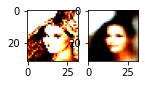

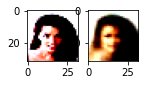

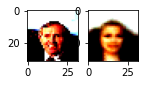

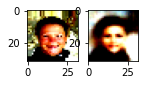

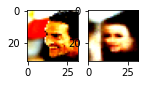

In [205]:
plot_imgs(0)
plot_imgs(10)
plot_imgs(20)
plot_imgs(30)
plot_imgs(40)
plt.show()
